# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory 'data': File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:12, 14.6MB/s]                              
SVHN Testing Set: 64.3MB [00:04, 15.1MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

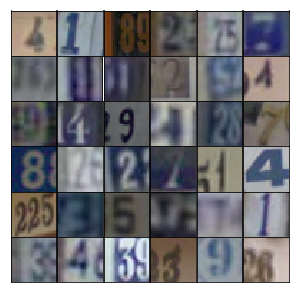

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=False, sharey=False, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
a = np.reshape(np.arange(12), [3,4])

In [8]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

### 转置坐标系

In [9]:
np.rollaxis(a, 1)

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

In [10]:
np.moveaxis(a, 1, 0)

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

In [11]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [12]:
def model_inputs(real_dim, z_dim):
    with tf.name_scope('input'):
        # real_dim = 32*32*3
        inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
        inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [13]:
def leaky_relus(x, alpha=0.2):
    return tf.maximum(x*alpha, x)

In [30]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        project = tf.layers.dense(z, 4*4*512, use_bias=False,activation=None, name='project')
        reshape = tf.reshape(project,[-1, 4, 4, 512], name='reshape')
        x = tf.layers.batch_normalization(reshape, training=training)
        conv1 = tf.identity(leaky_relus(x, alpha), name='conv1')
        #now 4*4*512
        
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=(2,2), padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.identity(leaky_relus(conv2, alpha), name='conv2')
        #now 8*8*256
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=(2,2), padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=training)
        conv3 = tf.identity(leaky_relus(conv3,alpha), name='conv3')
        #now 16*16*128
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(conv3, output_dim, 5, strides=(2,2), padding='same', name='logits')
        
        out = tf.tanh(logits, name='out')
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [31]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
#         x = tf.layers.batch_normalization(x, training=True)
        x = tf.identity(leaky_relus(x, alpha), name='conv1')
        #now 16*16*64
        
        conv2 = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.identity(leaky_relus(conv2, alpha), name='conv2')
        #now 8*8*128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.identity(leaky_relus(conv3, alpha), name='conv3')
        #now 4*4*256
        
#         conv4 = tf.reshape(conv4, [-1, 2*2*128])
        logits = tf.layers.dense(conv3, 1, name='logits')
        out = tf.nn.sigmoid(logits, name='out')
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [32]:
def model_loss(input_real, input_z, output_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    with tf.name_scope('loss'):
        g_model = generator(input_z, output_dim, alpha=alpha)
        d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
        d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

        d_loss = d_loss_real + d_loss_fake
        
        tf.summary.scalar('d_loss_real', d_loss_real)
        tf.summary.scalar('d_loss_fake', d_loss_fake)
        tf.summary.scalar('d_loss', d_loss)
        tf.summary.scalar('g_loss',g_loss)

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.name_scope('optimization'):
        # Optimize
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [34]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
        self.summary = tf.summary.merge_all()

Here is a function for displaying generated images.

In [35]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [36]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5),writer_dis=None,writer_gen=None):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _,d_summary = sess.run([net.d_opt, net.summary], feed_dict={net.input_real: x, net.input_z: batch_z})
                _,g_summary = sess.run([net.g_opt, net.summary], feed_dict={net.input_z: batch_z, net.input_real: x})
                if writer_dis != None:
                    writer_dis.add_summary(d_summary, steps)
                if writer_gen != None:
                    writer_gen.add_summary(g_summary, steps)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [37]:
tensorboard = '/tmp/dcgan/'

In [38]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 256
epochs = 20
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)
writer_discriminator = tf.summary.FileWriter(tensorboard+'discriminator',graph=tf.get_default_graph())
writer_generator = tf.summary.FileWriter(tensorboard+'generator')

Epoch 1/20... Discriminator Loss: 0.9998... Generator Loss: 1.3014
Epoch 1/20... Discriminator Loss: 0.7863... Generator Loss: 1.3398
Epoch 1/20... Discriminator Loss: 0.6638... Generator Loss: 1.6029
Epoch 1/20... Discriminator Loss: 0.9437... Generator Loss: 1.0706
Epoch 1/20... Discriminator Loss: 0.8263... Generator Loss: 1.5173
Epoch 1/20... Discriminator Loss: 0.6375... Generator Loss: 1.8799
Epoch 1/20... Discriminator Loss: 0.5898... Generator Loss: 1.9130
Epoch 1/20... Discriminator Loss: 0.5098... Generator Loss: 2.2062
Epoch 1/20... Discriminator Loss: 0.4949... Generator Loss: 2.6954
Epoch 1/20... Discriminator Loss: 0.4452... Generator Loss: 2.5354


/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


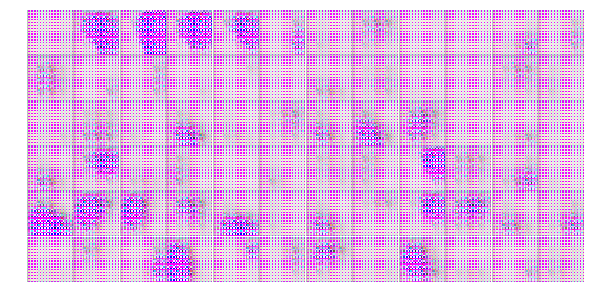

Epoch 1/20... Discriminator Loss: 0.5816... Generator Loss: 2.1064
Epoch 1/20... Discriminator Loss: 0.4661... Generator Loss: 2.6703
Epoch 1/20... Discriminator Loss: 0.4700... Generator Loss: 2.7881
Epoch 1/20... Discriminator Loss: 0.3810... Generator Loss: 3.2355
Epoch 1/20... Discriminator Loss: 0.3791... Generator Loss: 3.5562
Epoch 1/20... Discriminator Loss: 0.3687... Generator Loss: 3.5841
Epoch 1/20... Discriminator Loss: 0.3647... Generator Loss: 3.5709
Epoch 1/20... Discriminator Loss: 0.3632... Generator Loss: 3.7844
Epoch 1/20... Discriminator Loss: 0.3606... Generator Loss: 3.7763
Epoch 1/20... Discriminator Loss: 0.3557... Generator Loss: 3.9351


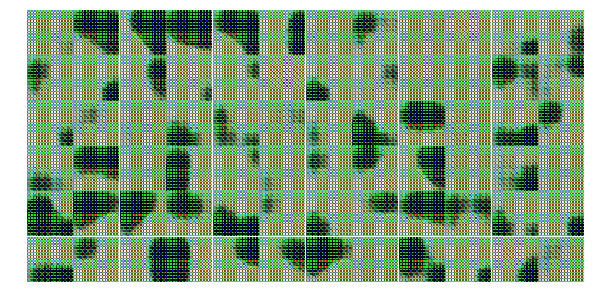

Epoch 1/20... Discriminator Loss: 0.3500... Generator Loss: 4.2355
Epoch 1/20... Discriminator Loss: 0.3996... Generator Loss: 3.5708
Epoch 1/20... Discriminator Loss: 0.3636... Generator Loss: 3.6178
Epoch 1/20... Discriminator Loss: 0.3502... Generator Loss: 4.2212
Epoch 1/20... Discriminator Loss: 0.3449... Generator Loss: 4.5064
Epoch 1/20... Discriminator Loss: 0.3528... Generator Loss: 4.0968
Epoch 1/20... Discriminator Loss: 0.3587... Generator Loss: 4.1783
Epoch 1/20... Discriminator Loss: 0.3470... Generator Loss: 4.2010
Epoch 2/20... Discriminator Loss: 0.3537... Generator Loss: 4.4043
Epoch 2/20... Discriminator Loss: 0.3737... Generator Loss: 4.2101


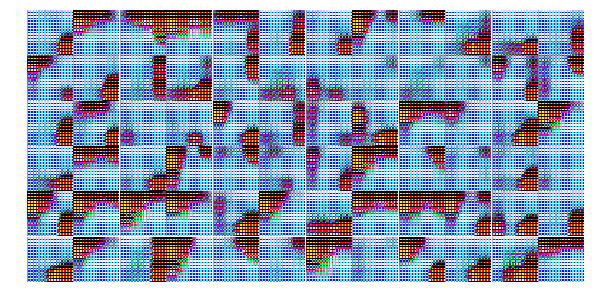

Epoch 2/20... Discriminator Loss: 0.3474... Generator Loss: 4.4366
Epoch 2/20... Discriminator Loss: 0.3440... Generator Loss: 4.6727
Epoch 2/20... Discriminator Loss: 0.4484... Generator Loss: 2.4150
Epoch 2/20... Discriminator Loss: 0.3429... Generator Loss: 4.9867
Epoch 2/20... Discriminator Loss: 0.3431... Generator Loss: 4.7354
Epoch 2/20... Discriminator Loss: 0.3395... Generator Loss: 4.8372
Epoch 2/20... Discriminator Loss: 0.3443... Generator Loss: 4.9328
Epoch 2/20... Discriminator Loss: 0.3418... Generator Loss: 5.0549
Epoch 2/20... Discriminator Loss: 0.3379... Generator Loss: 5.0593
Epoch 2/20... Discriminator Loss: 0.3374... Generator Loss: 5.0774


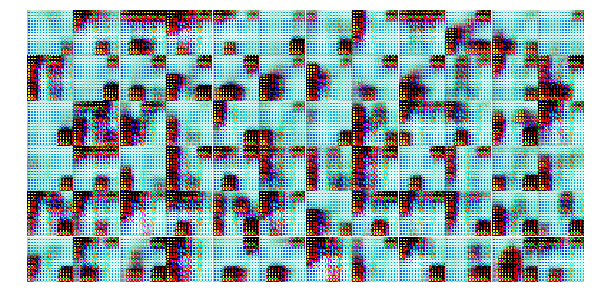

Epoch 2/20... Discriminator Loss: 0.3374... Generator Loss: 5.0534
Epoch 2/20... Discriminator Loss: 0.3375... Generator Loss: 5.0428
Epoch 2/20... Discriminator Loss: 0.3379... Generator Loss: 5.1895
Epoch 2/20... Discriminator Loss: 0.3367... Generator Loss: 5.3235
Epoch 2/20... Discriminator Loss: 0.3353... Generator Loss: 5.2297
Epoch 2/20... Discriminator Loss: 0.3478... Generator Loss: 4.8596
Epoch 2/20... Discriminator Loss: 0.4403... Generator Loss: 3.0321
Epoch 2/20... Discriminator Loss: 0.4046... Generator Loss: 3.9810
Epoch 2/20... Discriminator Loss: 0.3911... Generator Loss: 3.5643
Epoch 2/20... Discriminator Loss: 0.7965... Generator Loss: 1.3533


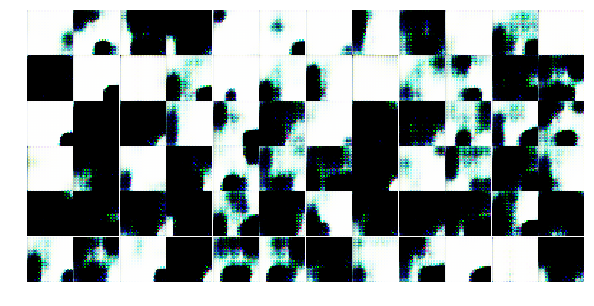

Epoch 2/20... Discriminator Loss: 0.4830... Generator Loss: 2.9132
Epoch 2/20... Discriminator Loss: 0.5444... Generator Loss: 2.6664
Epoch 2/20... Discriminator Loss: 0.4164... Generator Loss: 3.1481
Epoch 2/20... Discriminator Loss: 0.4495... Generator Loss: 2.8857
Epoch 2/20... Discriminator Loss: 0.4116... Generator Loss: 3.3998
Epoch 2/20... Discriminator Loss: 0.3834... Generator Loss: 3.6558
Epoch 2/20... Discriminator Loss: 0.4147... Generator Loss: 3.4331
Epoch 3/20... Discriminator Loss: 0.3970... Generator Loss: 3.5468
Epoch 3/20... Discriminator Loss: 0.4728... Generator Loss: 2.4422
Epoch 3/20... Discriminator Loss: 0.4064... Generator Loss: 4.2545


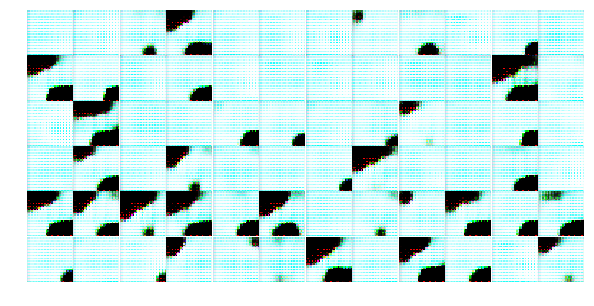

Epoch 3/20... Discriminator Loss: 0.4630... Generator Loss: 2.6272
Epoch 3/20... Discriminator Loss: 0.3864... Generator Loss: 4.4810
Epoch 3/20... Discriminator Loss: 0.3798... Generator Loss: 4.4542
Epoch 3/20... Discriminator Loss: 0.3630... Generator Loss: 4.8985
Epoch 3/20... Discriminator Loss: 0.3527... Generator Loss: 5.6982
Epoch 3/20... Discriminator Loss: 0.3365... Generator Loss: 5.8646
Epoch 3/20... Discriminator Loss: 0.3380... Generator Loss: 5.9424
Epoch 3/20... Discriminator Loss: 0.3331... Generator Loss: 5.9823
Epoch 3/20... Discriminator Loss: 0.3308... Generator Loss: 6.0233
Epoch 3/20... Discriminator Loss: 0.3342... Generator Loss: 6.0194


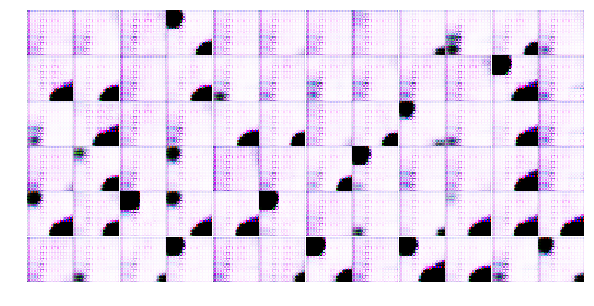

Epoch 3/20... Discriminator Loss: 0.3332... Generator Loss: 5.8852
Epoch 3/20... Discriminator Loss: 0.3338... Generator Loss: 5.7699
Epoch 3/20... Discriminator Loss: 0.3300... Generator Loss: 5.9469
Epoch 3/20... Discriminator Loss: 0.3334... Generator Loss: 5.9848
Epoch 3/20... Discriminator Loss: 0.3349... Generator Loss: 5.6470
Epoch 3/20... Discriminator Loss: 0.3403... Generator Loss: 5.2801
Epoch 3/20... Discriminator Loss: 0.3395... Generator Loss: 5.5135
Epoch 3/20... Discriminator Loss: 0.3489... Generator Loss: 5.6076
Epoch 3/20... Discriminator Loss: 0.3327... Generator Loss: 5.7227
Epoch 3/20... Discriminator Loss: 0.3448... Generator Loss: 4.9985


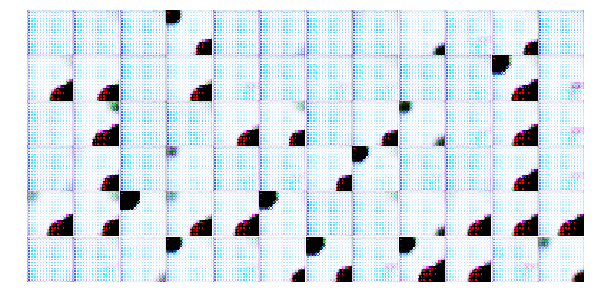

Epoch 3/20... Discriminator Loss: 0.3321... Generator Loss: 6.6378
Epoch 3/20... Discriminator Loss: 0.3313... Generator Loss: 6.5604
Epoch 3/20... Discriminator Loss: 0.3349... Generator Loss: 5.7983
Epoch 3/20... Discriminator Loss: 0.3639... Generator Loss: 3.6345
Epoch 3/20... Discriminator Loss: 0.4051... Generator Loss: 3.5245
Epoch 3/20... Discriminator Loss: 0.4160... Generator Loss: 3.5660
Epoch 4/20... Discriminator Loss: 0.4331... Generator Loss: 3.0415
Epoch 4/20... Discriminator Loss: 0.3934... Generator Loss: 3.4161
Epoch 4/20... Discriminator Loss: 0.3930... Generator Loss: 4.1298
Epoch 4/20... Discriminator Loss: 0.4223... Generator Loss: 4.6116


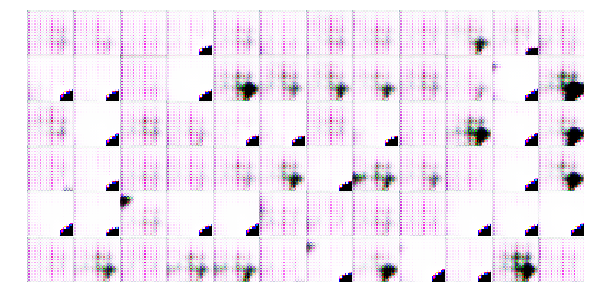

Epoch 4/20... Discriminator Loss: 0.5336... Generator Loss: 2.3447
Epoch 4/20... Discriminator Loss: 0.5408... Generator Loss: 2.3195
Epoch 4/20... Discriminator Loss: 0.4642... Generator Loss: 2.7620
Epoch 4/20... Discriminator Loss: 0.9192... Generator Loss: 4.5306
Epoch 4/20... Discriminator Loss: 0.6157... Generator Loss: 1.8667
Epoch 4/20... Discriminator Loss: 0.4786... Generator Loss: 2.6153
Epoch 4/20... Discriminator Loss: 0.4034... Generator Loss: 3.8871
Epoch 4/20... Discriminator Loss: 0.5645... Generator Loss: 3.2905
Epoch 4/20... Discriminator Loss: 0.4325... Generator Loss: 3.1424
Epoch 4/20... Discriminator Loss: 0.4579... Generator Loss: 3.1171


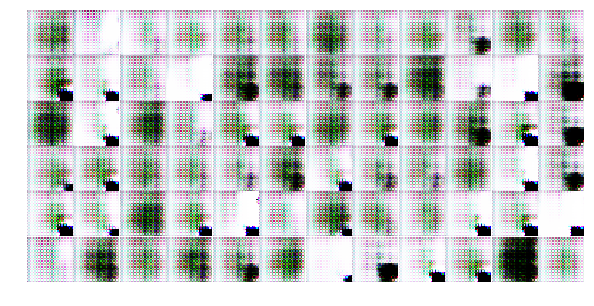

Epoch 4/20... Discriminator Loss: 0.4473... Generator Loss: 2.9666
Epoch 4/20... Discriminator Loss: 0.4402... Generator Loss: 2.8381
Epoch 4/20... Discriminator Loss: 0.4487... Generator Loss: 3.0563
Epoch 4/20... Discriminator Loss: 0.4869... Generator Loss: 2.9037
Epoch 4/20... Discriminator Loss: 0.8372... Generator Loss: 4.4254
Epoch 4/20... Discriminator Loss: 0.4164... Generator Loss: 3.7419
Epoch 4/20... Discriminator Loss: 0.5681... Generator Loss: 4.0522
Epoch 4/20... Discriminator Loss: 0.6651... Generator Loss: 3.7289
Epoch 4/20... Discriminator Loss: 0.6396... Generator Loss: 2.7217
Epoch 4/20... Discriminator Loss: 0.5669... Generator Loss: 1.9938


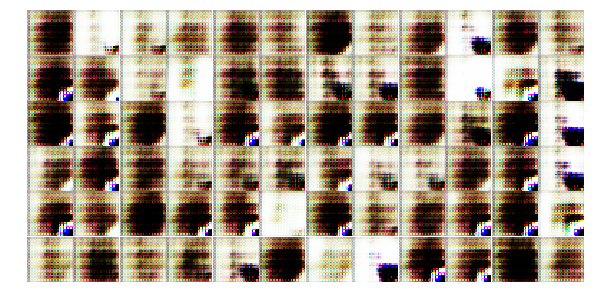

Epoch 4/20... Discriminator Loss: 0.4501... Generator Loss: 2.7863
Epoch 4/20... Discriminator Loss: 0.5034... Generator Loss: 3.2639
Epoch 4/20... Discriminator Loss: 0.4599... Generator Loss: 3.3619
Epoch 4/20... Discriminator Loss: 0.4892... Generator Loss: 2.6608
Epoch 5/20... Discriminator Loss: 0.4759... Generator Loss: 2.6741
Epoch 5/20... Discriminator Loss: 0.5608... Generator Loss: 2.8325
Epoch 5/20... Discriminator Loss: 0.4753... Generator Loss: 2.6487
Epoch 5/20... Discriminator Loss: 0.7076... Generator Loss: 1.5330
Epoch 5/20... Discriminator Loss: 0.5576... Generator Loss: 2.1556
Epoch 5/20... Discriminator Loss: 0.6078... Generator Loss: 2.2486


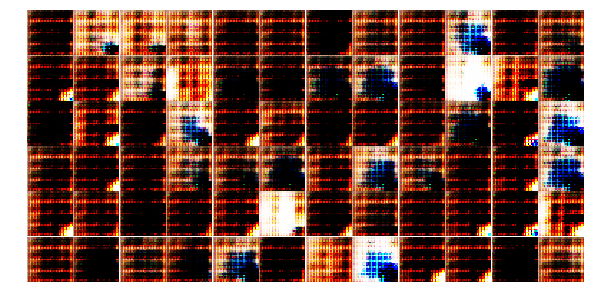

Epoch 5/20... Discriminator Loss: 0.5353... Generator Loss: 2.3484
Epoch 5/20... Discriminator Loss: 0.5521... Generator Loss: 3.1293
Epoch 5/20... Discriminator Loss: 0.5210... Generator Loss: 2.4971
Epoch 5/20... Discriminator Loss: 0.5778... Generator Loss: 2.2626
Epoch 5/20... Discriminator Loss: 1.0089... Generator Loss: 1.0191
Epoch 5/20... Discriminator Loss: 0.7352... Generator Loss: 1.7329
Epoch 5/20... Discriminator Loss: 0.5830... Generator Loss: 2.8032
Epoch 5/20... Discriminator Loss: 0.6518... Generator Loss: 2.5475
Epoch 5/20... Discriminator Loss: 0.6676... Generator Loss: 2.0373
Epoch 5/20... Discriminator Loss: 0.4974... Generator Loss: 3.0515


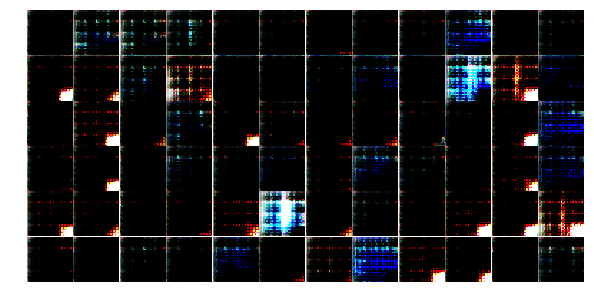

Epoch 5/20... Discriminator Loss: 0.4788... Generator Loss: 3.4496
Epoch 5/20... Discriminator Loss: 0.4177... Generator Loss: 3.9189
Epoch 5/20... Discriminator Loss: 0.4193... Generator Loss: 3.3914
Epoch 5/20... Discriminator Loss: 0.5071... Generator Loss: 2.4347
Epoch 5/20... Discriminator Loss: 0.5625... Generator Loss: 2.3569
Epoch 5/20... Discriminator Loss: 0.6805... Generator Loss: 2.4279
Epoch 5/20... Discriminator Loss: 0.8700... Generator Loss: 1.1688
Epoch 5/20... Discriminator Loss: 0.6164... Generator Loss: 2.1644
Epoch 5/20... Discriminator Loss: 0.7356... Generator Loss: 2.0397
Epoch 5/20... Discriminator Loss: 0.4889... Generator Loss: 3.3047


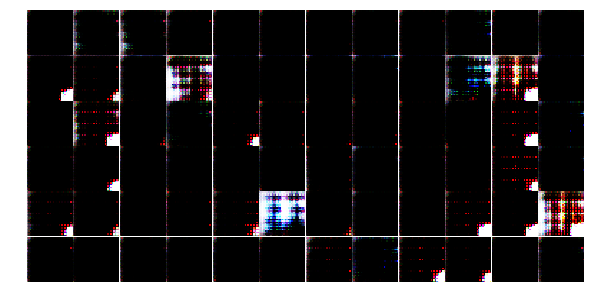

Epoch 5/20... Discriminator Loss: 0.7187... Generator Loss: 2.9428
Epoch 5/20... Discriminator Loss: 0.5299... Generator Loss: 2.4720
Epoch 5/20... Discriminator Loss: 0.8019... Generator Loss: 1.5524
Epoch 6/20... Discriminator Loss: 0.4881... Generator Loss: 3.3098
Epoch 6/20... Discriminator Loss: 0.4567... Generator Loss: 2.9892
Epoch 6/20... Discriminator Loss: 0.4704... Generator Loss: 2.6106
Epoch 6/20... Discriminator Loss: 0.7579... Generator Loss: 2.2775
Epoch 6/20... Discriminator Loss: 0.4577... Generator Loss: 2.8846
Epoch 6/20... Discriminator Loss: 0.4492... Generator Loss: 2.9703
Epoch 6/20... Discriminator Loss: 0.6757... Generator Loss: 1.5366


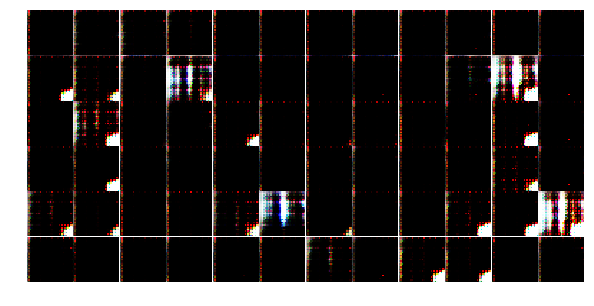

Epoch 6/20... Discriminator Loss: 1.0391... Generator Loss: 2.6884
Epoch 6/20... Discriminator Loss: 0.5407... Generator Loss: 2.6709
Epoch 6/20... Discriminator Loss: 0.6087... Generator Loss: 1.9941
Epoch 6/20... Discriminator Loss: 0.6720... Generator Loss: 1.8716
Epoch 6/20... Discriminator Loss: 0.5901... Generator Loss: 2.4833
Epoch 6/20... Discriminator Loss: 0.7041... Generator Loss: 1.5530
Epoch 6/20... Discriminator Loss: 0.8063... Generator Loss: 1.2955
Epoch 6/20... Discriminator Loss: 0.7929... Generator Loss: 3.3980
Epoch 6/20... Discriminator Loss: 0.5643... Generator Loss: 3.5667
Epoch 6/20... Discriminator Loss: 0.5342... Generator Loss: 3.5970


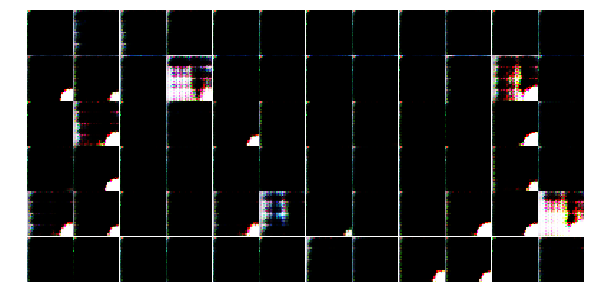

Epoch 6/20... Discriminator Loss: 0.6390... Generator Loss: 1.6590
Epoch 6/20... Discriminator Loss: 0.8266... Generator Loss: 2.7609
Epoch 6/20... Discriminator Loss: 0.5096... Generator Loss: 2.6985
Epoch 6/20... Discriminator Loss: 0.7225... Generator Loss: 1.5196
Epoch 6/20... Discriminator Loss: 1.0230... Generator Loss: 1.4121
Epoch 6/20... Discriminator Loss: 0.8874... Generator Loss: 2.5249
Epoch 6/20... Discriminator Loss: 0.8486... Generator Loss: 1.6468
Epoch 6/20... Discriminator Loss: 0.5311... Generator Loss: 2.4990
Epoch 6/20... Discriminator Loss: 0.8847... Generator Loss: 1.1976
Epoch 6/20... Discriminator Loss: 0.5444... Generator Loss: 2.5970


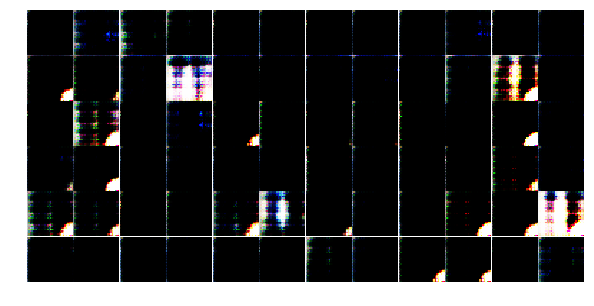

Epoch 6/20... Discriminator Loss: 0.7433... Generator Loss: 1.3502
Epoch 6/20... Discriminator Loss: 0.6590... Generator Loss: 2.2527
Epoch 7/20... Discriminator Loss: 0.6953... Generator Loss: 1.8941
Epoch 7/20... Discriminator Loss: 0.8195... Generator Loss: 2.5275
Epoch 7/20... Discriminator Loss: 0.6257... Generator Loss: 1.9491
Epoch 7/20... Discriminator Loss: 0.5014... Generator Loss: 2.5627
Epoch 7/20... Discriminator Loss: 0.5718... Generator Loss: 1.9869
Epoch 7/20... Discriminator Loss: 0.5314... Generator Loss: 2.7578
Epoch 7/20... Discriminator Loss: 0.8926... Generator Loss: 1.8242
Epoch 7/20... Discriminator Loss: 2.1651... Generator Loss: 0.9258


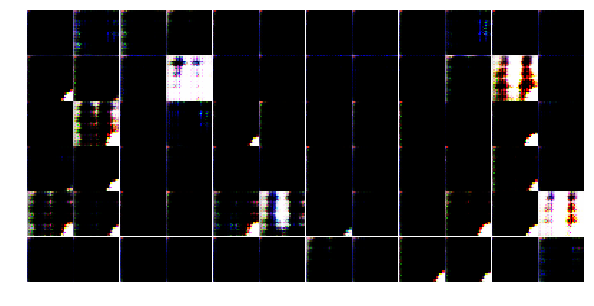

Epoch 7/20... Discriminator Loss: 0.8849... Generator Loss: 2.1822
Epoch 7/20... Discriminator Loss: 0.6467... Generator Loss: 1.8977
Epoch 7/20... Discriminator Loss: 0.7880... Generator Loss: 1.4207
Epoch 7/20... Discriminator Loss: 0.6560... Generator Loss: 2.2337
Epoch 7/20... Discriminator Loss: 0.8089... Generator Loss: 1.7510
Epoch 7/20... Discriminator Loss: 0.8564... Generator Loss: 1.5897
Epoch 7/20... Discriminator Loss: 0.4728... Generator Loss: 2.7147
Epoch 7/20... Discriminator Loss: 1.2298... Generator Loss: 1.9509
Epoch 7/20... Discriminator Loss: 0.6064... Generator Loss: 2.3843
Epoch 7/20... Discriminator Loss: 0.7177... Generator Loss: 1.7808


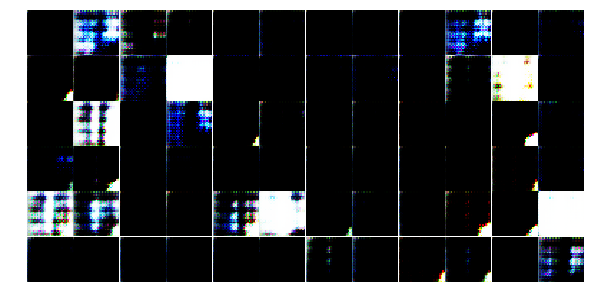

Epoch 7/20... Discriminator Loss: 0.7792... Generator Loss: 1.5241
Epoch 7/20... Discriminator Loss: 0.6775... Generator Loss: 1.7497
Epoch 7/20... Discriminator Loss: 0.8580... Generator Loss: 1.5330
Epoch 7/20... Discriminator Loss: 0.5358... Generator Loss: 3.0483
Epoch 7/20... Discriminator Loss: 0.5549... Generator Loss: 2.2177
Epoch 7/20... Discriminator Loss: 0.4832... Generator Loss: 2.6311
Epoch 7/20... Discriminator Loss: 0.8010... Generator Loss: 1.3009
Epoch 7/20... Discriminator Loss: 1.7459... Generator Loss: 0.9816
Epoch 7/20... Discriminator Loss: 0.8292... Generator Loss: 1.4192
Epoch 7/20... Discriminator Loss: 1.1219... Generator Loss: 1.0323


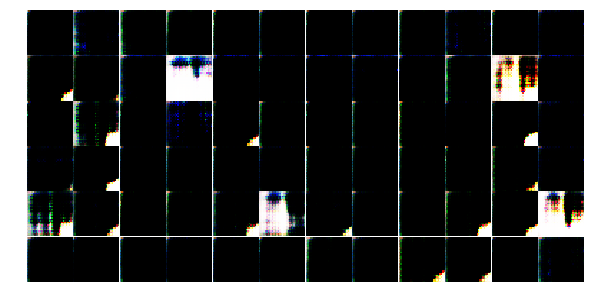

Epoch 8/20... Discriminator Loss: 0.7254... Generator Loss: 2.1524
Epoch 8/20... Discriminator Loss: 0.7589... Generator Loss: 1.6777
Epoch 8/20... Discriminator Loss: 0.9258... Generator Loss: 1.2604
Epoch 8/20... Discriminator Loss: 1.0107... Generator Loss: 1.2446
Epoch 8/20... Discriminator Loss: 1.3219... Generator Loss: 0.9639
Epoch 8/20... Discriminator Loss: 0.7612... Generator Loss: 1.9447
Epoch 8/20... Discriminator Loss: 0.7740... Generator Loss: 2.5150
Epoch 8/20... Discriminator Loss: 0.4581... Generator Loss: 2.7616
Epoch 8/20... Discriminator Loss: 0.5484... Generator Loss: 2.1034
Epoch 8/20... Discriminator Loss: 0.5775... Generator Loss: 2.2746


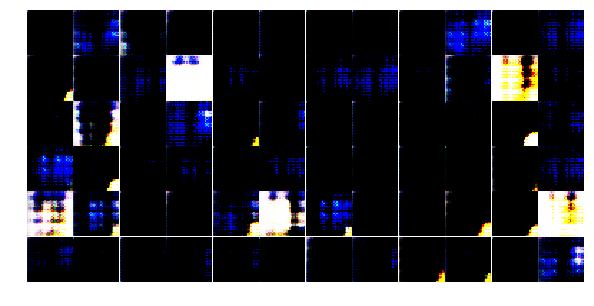

Epoch 8/20... Discriminator Loss: 0.4199... Generator Loss: 3.6679
Epoch 8/20... Discriminator Loss: 0.4544... Generator Loss: 2.9798
Epoch 8/20... Discriminator Loss: 0.6162... Generator Loss: 2.5201
Epoch 8/20... Discriminator Loss: 0.5380... Generator Loss: 2.1555
Epoch 8/20... Discriminator Loss: 0.8536... Generator Loss: 1.1258
Epoch 8/20... Discriminator Loss: 0.8589... Generator Loss: 2.9570
Epoch 8/20... Discriminator Loss: 0.6806... Generator Loss: 1.6295
Epoch 8/20... Discriminator Loss: 0.9865... Generator Loss: 1.2019
Epoch 8/20... Discriminator Loss: 0.7666... Generator Loss: 1.4726
Epoch 8/20... Discriminator Loss: 0.8113... Generator Loss: 1.5123


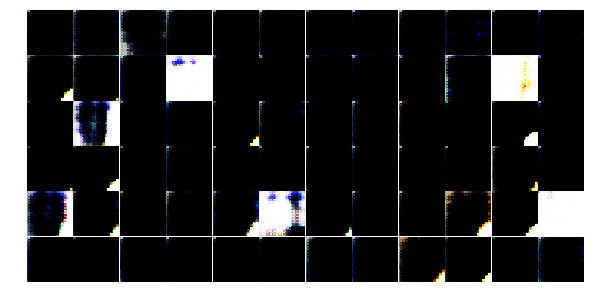

Epoch 8/20... Discriminator Loss: 0.7249... Generator Loss: 1.6093
Epoch 8/20... Discriminator Loss: 0.6994... Generator Loss: 2.1924
Epoch 8/20... Discriminator Loss: 1.0724... Generator Loss: 1.6793
Epoch 8/20... Discriminator Loss: 0.9653... Generator Loss: 1.1053
Epoch 8/20... Discriminator Loss: 0.5614... Generator Loss: 2.3254
Epoch 8/20... Discriminator Loss: 0.4811... Generator Loss: 2.6350
Epoch 8/20... Discriminator Loss: 0.6165... Generator Loss: 1.8422
Epoch 8/20... Discriminator Loss: 1.2534... Generator Loss: 0.7710
Epoch 8/20... Discriminator Loss: 1.6388... Generator Loss: 0.7816
Epoch 9/20... Discriminator Loss: 2.3885... Generator Loss: 0.5093


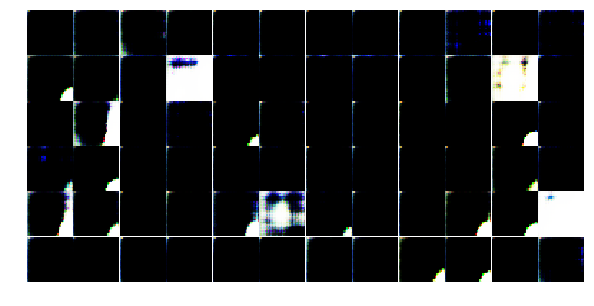

Epoch 9/20... Discriminator Loss: 0.8545... Generator Loss: 1.7119
Epoch 9/20... Discriminator Loss: 0.6510... Generator Loss: 1.9776
Epoch 9/20... Discriminator Loss: 0.5695... Generator Loss: 2.5299
Epoch 9/20... Discriminator Loss: 0.5997... Generator Loss: 2.4086
Epoch 9/20... Discriminator Loss: 0.4433... Generator Loss: 3.0633
Epoch 9/20... Discriminator Loss: 0.5727... Generator Loss: 3.0117
Epoch 9/20... Discriminator Loss: 0.6939... Generator Loss: 2.4639
Epoch 9/20... Discriminator Loss: 0.4266... Generator Loss: 3.3107
Epoch 9/20... Discriminator Loss: 0.4985... Generator Loss: 2.7356
Epoch 9/20... Discriminator Loss: 0.4072... Generator Loss: 3.6052


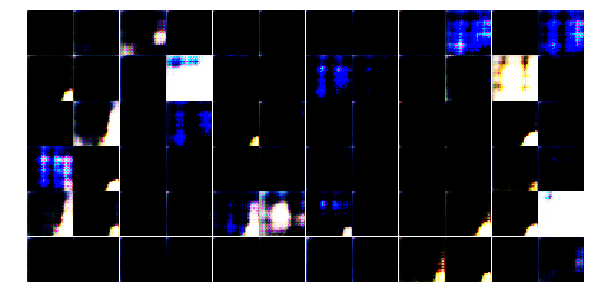

Epoch 9/20... Discriminator Loss: 0.6409... Generator Loss: 3.6019
Epoch 9/20... Discriminator Loss: 0.8281... Generator Loss: 1.4294
Epoch 9/20... Discriminator Loss: 1.0027... Generator Loss: 3.4064
Epoch 9/20... Discriminator Loss: 0.6288... Generator Loss: 3.4267
Epoch 9/20... Discriminator Loss: 0.8533... Generator Loss: 2.1885
Epoch 9/20... Discriminator Loss: 1.0389... Generator Loss: 1.2767
Epoch 9/20... Discriminator Loss: 1.1253... Generator Loss: 1.0255
Epoch 9/20... Discriminator Loss: 1.0843... Generator Loss: 0.9667
Epoch 9/20... Discriminator Loss: 1.2524... Generator Loss: 0.7469
Epoch 9/20... Discriminator Loss: 1.6975... Generator Loss: 1.1256


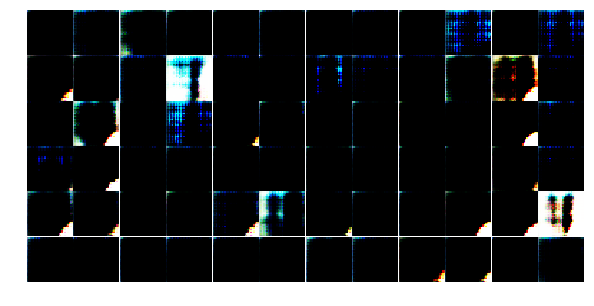

Epoch 9/20... Discriminator Loss: 0.6639... Generator Loss: 2.3209
Epoch 9/20... Discriminator Loss: 0.5155... Generator Loss: 2.3019
Epoch 9/20... Discriminator Loss: 0.8247... Generator Loss: 1.5125
Epoch 9/20... Discriminator Loss: 0.9807... Generator Loss: 1.5096
Epoch 9/20... Discriminator Loss: 0.5419... Generator Loss: 2.2845
Epoch 9/20... Discriminator Loss: 0.5942... Generator Loss: 2.5938
Epoch 9/20... Discriminator Loss: 0.6574... Generator Loss: 2.2549
Epoch 9/20... Discriminator Loss: 0.5193... Generator Loss: 2.5695
Epoch 10/20... Discriminator Loss: 0.6986... Generator Loss: 1.7607
Epoch 10/20... Discriminator Loss: 0.6544... Generator Loss: 1.8858


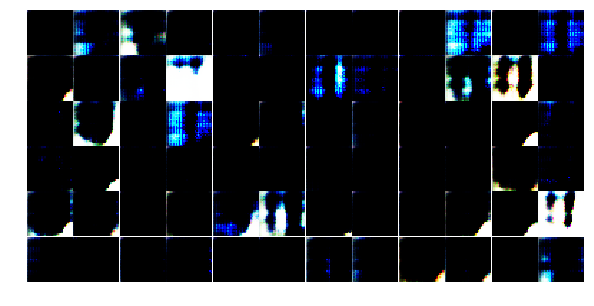

Epoch 10/20... Discriminator Loss: 0.5746... Generator Loss: 2.8433
Epoch 10/20... Discriminator Loss: 0.6418... Generator Loss: 2.1511
Epoch 10/20... Discriminator Loss: 0.6777... Generator Loss: 1.8158
Epoch 10/20... Discriminator Loss: 0.5822... Generator Loss: 2.8667
Epoch 10/20... Discriminator Loss: 1.1492... Generator Loss: 1.0141
Epoch 10/20... Discriminator Loss: 0.7282... Generator Loss: 2.8628
Epoch 10/20... Discriminator Loss: 0.6835... Generator Loss: 2.2723
Epoch 10/20... Discriminator Loss: 0.6609... Generator Loss: 2.2256
Epoch 10/20... Discriminator Loss: 0.6390... Generator Loss: 2.0399
Epoch 10/20... Discriminator Loss: 0.8157... Generator Loss: 1.9641


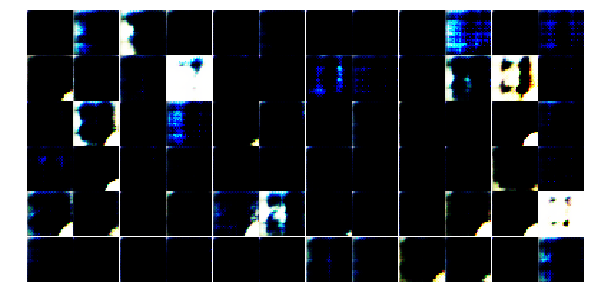

Epoch 10/20... Discriminator Loss: 0.6858... Generator Loss: 2.3382
Epoch 10/20... Discriminator Loss: 0.6089... Generator Loss: 1.9796
Epoch 10/20... Discriminator Loss: 0.7179... Generator Loss: 2.0034
Epoch 10/20... Discriminator Loss: 0.9782... Generator Loss: 1.1862
Epoch 10/20... Discriminator Loss: 0.9626... Generator Loss: 1.4033
Epoch 10/20... Discriminator Loss: 0.7375... Generator Loss: 2.9113
Epoch 10/20... Discriminator Loss: 0.5824... Generator Loss: 3.7957
Epoch 10/20... Discriminator Loss: 0.5117... Generator Loss: 3.2055
Epoch 10/20... Discriminator Loss: 0.5298... Generator Loss: 2.5182
Epoch 10/20... Discriminator Loss: 0.5953... Generator Loss: 2.1422


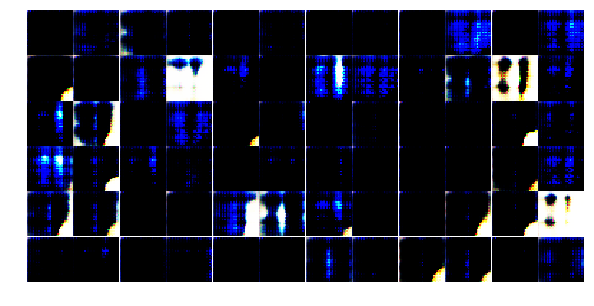

Epoch 10/20... Discriminator Loss: 0.4231... Generator Loss: 3.4944
Epoch 10/20... Discriminator Loss: 0.6188... Generator Loss: 2.4521
Epoch 10/20... Discriminator Loss: 1.0367... Generator Loss: 1.0229
Epoch 10/20... Discriminator Loss: 0.4756... Generator Loss: 3.3585
Epoch 10/20... Discriminator Loss: 0.5568... Generator Loss: 2.4974
Epoch 10/20... Discriminator Loss: 0.8929... Generator Loss: 2.2487
Epoch 10/20... Discriminator Loss: 0.8000... Generator Loss: 2.0343
Epoch 11/20... Discriminator Loss: 0.5322... Generator Loss: 2.4385
Epoch 11/20... Discriminator Loss: 0.4990... Generator Loss: 2.6773
Epoch 11/20... Discriminator Loss: 0.8889... Generator Loss: 1.3676


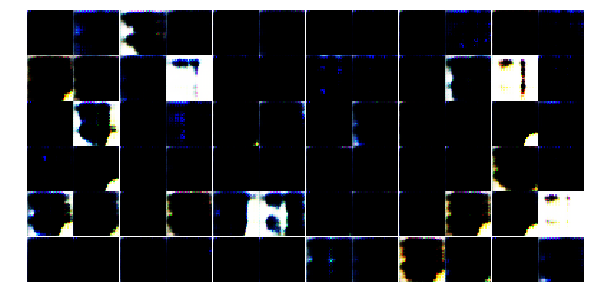

Epoch 11/20... Discriminator Loss: 0.5364... Generator Loss: 2.9491
Epoch 11/20... Discriminator Loss: 0.4288... Generator Loss: 4.0843
Epoch 11/20... Discriminator Loss: 0.7813... Generator Loss: 2.2348
Epoch 11/20... Discriminator Loss: 1.7436... Generator Loss: 0.6633
Epoch 11/20... Discriminator Loss: 0.6074... Generator Loss: 2.3701
Epoch 11/20... Discriminator Loss: 0.6511... Generator Loss: 2.3310
Epoch 11/20... Discriminator Loss: 0.5321... Generator Loss: 2.6765
Epoch 11/20... Discriminator Loss: 0.6535... Generator Loss: 1.7704
Epoch 11/20... Discriminator Loss: 0.7850... Generator Loss: 1.5422
Epoch 11/20... Discriminator Loss: 1.2493... Generator Loss: 1.6173


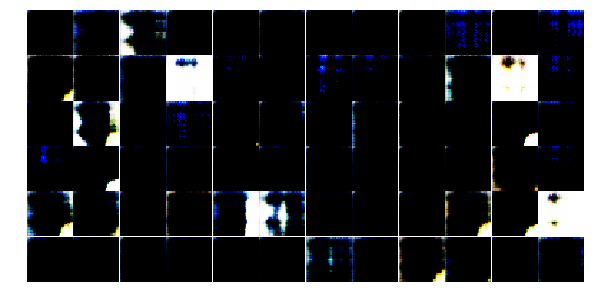

Epoch 11/20... Discriminator Loss: 0.9151... Generator Loss: 2.5854
Epoch 11/20... Discriminator Loss: 1.1776... Generator Loss: 0.8378
Epoch 11/20... Discriminator Loss: 0.9061... Generator Loss: 1.3786
Epoch 11/20... Discriminator Loss: 0.5481... Generator Loss: 2.2104
Epoch 11/20... Discriminator Loss: 0.4884... Generator Loss: 2.6724
Epoch 11/20... Discriminator Loss: 0.6485... Generator Loss: 2.3206
Epoch 11/20... Discriminator Loss: 1.1927... Generator Loss: 1.4176
Epoch 11/20... Discriminator Loss: 0.6561... Generator Loss: 2.4661
Epoch 11/20... Discriminator Loss: 0.8460... Generator Loss: 1.3421
Epoch 11/20... Discriminator Loss: 0.8770... Generator Loss: 1.3533


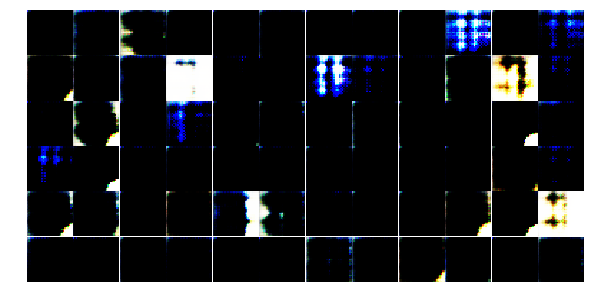

Epoch 11/20... Discriminator Loss: 0.6832... Generator Loss: 2.1511
Epoch 11/20... Discriminator Loss: 0.6833... Generator Loss: 2.1127
Epoch 11/20... Discriminator Loss: 0.9890... Generator Loss: 1.1138
Epoch 11/20... Discriminator Loss: 0.7308... Generator Loss: 2.1559
Epoch 11/20... Discriminator Loss: 0.6944... Generator Loss: 2.5078
Epoch 12/20... Discriminator Loss: 1.7525... Generator Loss: 0.5096
Epoch 12/20... Discriminator Loss: 0.7983... Generator Loss: 1.6039
Epoch 12/20... Discriminator Loss: 0.7100... Generator Loss: 1.8880
Epoch 12/20... Discriminator Loss: 0.8802... Generator Loss: 1.3573
Epoch 12/20... Discriminator Loss: 0.6471... Generator Loss: 2.4416


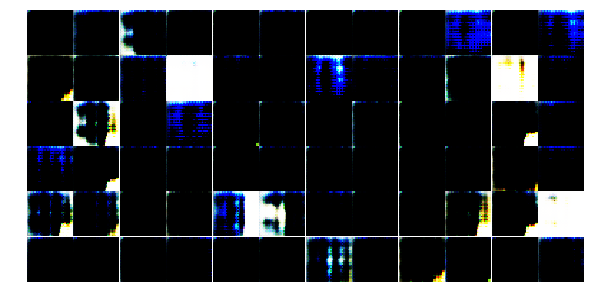

Epoch 12/20... Discriminator Loss: 0.4851... Generator Loss: 3.3745
Epoch 12/20... Discriminator Loss: 0.6933... Generator Loss: 1.9477
Epoch 12/20... Discriminator Loss: 0.8211... Generator Loss: 1.2193
Epoch 12/20... Discriminator Loss: 0.6293... Generator Loss: 1.7266
Epoch 12/20... Discriminator Loss: 0.8066... Generator Loss: 2.0104
Epoch 12/20... Discriminator Loss: 0.6123... Generator Loss: 1.9180
Epoch 12/20... Discriminator Loss: 0.5209... Generator Loss: 3.5449
Epoch 12/20... Discriminator Loss: 0.5478... Generator Loss: 2.6215
Epoch 12/20... Discriminator Loss: 0.7132... Generator Loss: 1.7047
Epoch 12/20... Discriminator Loss: 0.7696... Generator Loss: 2.0217


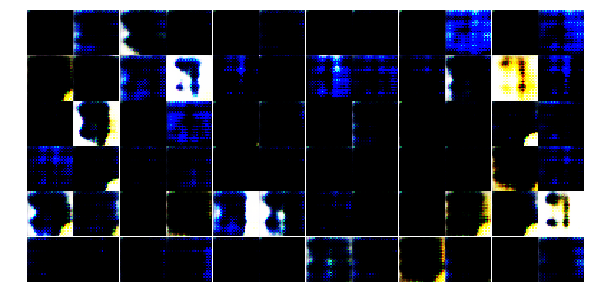

Epoch 12/20... Discriminator Loss: 0.7571... Generator Loss: 1.6917
Epoch 12/20... Discriminator Loss: 0.5810... Generator Loss: 2.2096
Epoch 12/20... Discriminator Loss: 0.7777... Generator Loss: 1.7014
Epoch 12/20... Discriminator Loss: 0.5843... Generator Loss: 2.5091
Epoch 12/20... Discriminator Loss: 0.8444... Generator Loss: 1.9383
Epoch 12/20... Discriminator Loss: 0.8938... Generator Loss: 1.6801
Epoch 12/20... Discriminator Loss: 0.8194... Generator Loss: 1.3286
Epoch 12/20... Discriminator Loss: 0.6362... Generator Loss: 2.2557
Epoch 12/20... Discriminator Loss: 1.2158... Generator Loss: 1.9433
Epoch 12/20... Discriminator Loss: 0.8428... Generator Loss: 2.3795


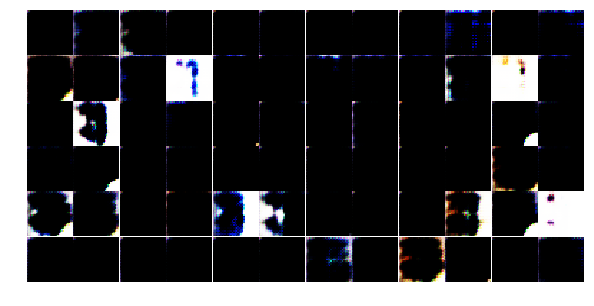

Epoch 12/20... Discriminator Loss: 0.6392... Generator Loss: 2.5539
Epoch 12/20... Discriminator Loss: 0.5414... Generator Loss: 2.2728
Epoch 12/20... Discriminator Loss: 0.5576... Generator Loss: 2.3658
Epoch 12/20... Discriminator Loss: 0.4836... Generator Loss: 2.9868
Epoch 13/20... Discriminator Loss: 0.7340... Generator Loss: 2.7253
Epoch 13/20... Discriminator Loss: 0.9217... Generator Loss: 1.7397
Epoch 13/20... Discriminator Loss: 1.2633... Generator Loss: 1.2358
Epoch 13/20... Discriminator Loss: 0.8251... Generator Loss: 1.5143
Epoch 13/20... Discriminator Loss: 0.8762... Generator Loss: 1.8969
Epoch 13/20... Discriminator Loss: 0.5763... Generator Loss: 3.5354


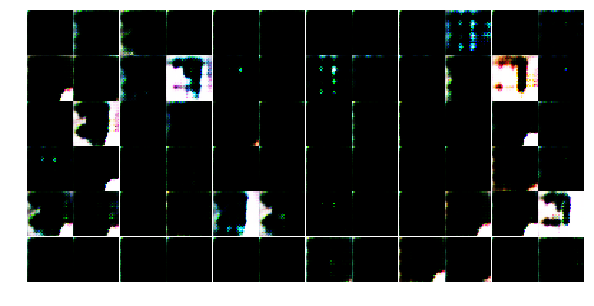

Epoch 13/20... Discriminator Loss: 0.8698... Generator Loss: 1.3521
Epoch 13/20... Discriminator Loss: 0.6891... Generator Loss: 3.1563
Epoch 13/20... Discriminator Loss: 0.6269... Generator Loss: 2.1211
Epoch 13/20... Discriminator Loss: 0.8052... Generator Loss: 1.5305
Epoch 13/20... Discriminator Loss: 1.0036... Generator Loss: 1.3464
Epoch 13/20... Discriminator Loss: 0.9890... Generator Loss: 1.1953
Epoch 13/20... Discriminator Loss: 0.8102... Generator Loss: 1.8365
Epoch 13/20... Discriminator Loss: 0.7424... Generator Loss: 1.4896
Epoch 13/20... Discriminator Loss: 0.9169... Generator Loss: 1.5315
Epoch 13/20... Discriminator Loss: 0.7404... Generator Loss: 1.7656


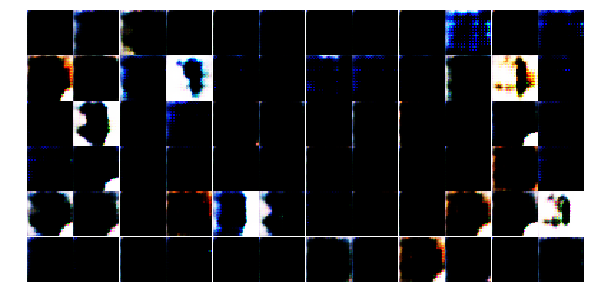

Epoch 13/20... Discriminator Loss: 0.9309... Generator Loss: 1.2971
Epoch 13/20... Discriminator Loss: 0.9676... Generator Loss: 1.4615
Epoch 13/20... Discriminator Loss: 0.8678... Generator Loss: 1.8300
Epoch 13/20... Discriminator Loss: 0.6829... Generator Loss: 1.8533
Epoch 13/20... Discriminator Loss: 0.7206... Generator Loss: 2.0345
Epoch 13/20... Discriminator Loss: 0.7364... Generator Loss: 1.5774
Epoch 13/20... Discriminator Loss: 0.7262... Generator Loss: 2.1589
Epoch 13/20... Discriminator Loss: 0.6547... Generator Loss: 2.6652
Epoch 13/20... Discriminator Loss: 0.4850... Generator Loss: 3.6555
Epoch 13/20... Discriminator Loss: 0.5877... Generator Loss: 3.0832


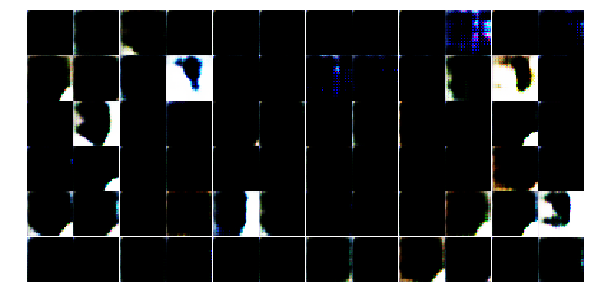

Epoch 13/20... Discriminator Loss: 0.6176... Generator Loss: 2.3008
Epoch 13/20... Discriminator Loss: 0.6058... Generator Loss: 1.7398
Epoch 13/20... Discriminator Loss: 0.6980... Generator Loss: 2.6858
Epoch 14/20... Discriminator Loss: 0.7350... Generator Loss: 2.0867
Epoch 14/20... Discriminator Loss: 0.5801... Generator Loss: 2.7646
Epoch 14/20... Discriminator Loss: 0.5743... Generator Loss: 2.5741
Epoch 14/20... Discriminator Loss: 0.7818... Generator Loss: 1.8012
Epoch 14/20... Discriminator Loss: 0.9446... Generator Loss: 1.3310
Epoch 14/20... Discriminator Loss: 1.0327... Generator Loss: 1.9200
Epoch 14/20... Discriminator Loss: 0.8574... Generator Loss: 1.8541


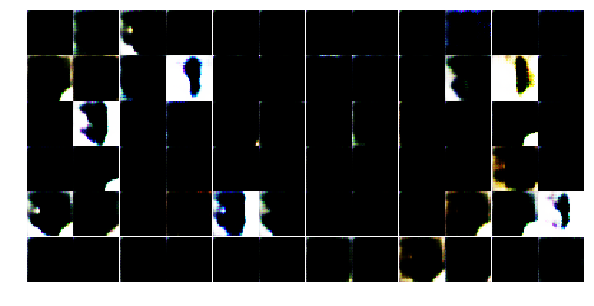

Epoch 14/20... Discriminator Loss: 0.8784... Generator Loss: 1.2878
Epoch 14/20... Discriminator Loss: 0.7921... Generator Loss: 1.2161
Epoch 14/20... Discriminator Loss: 0.6908... Generator Loss: 2.2514
Epoch 14/20... Discriminator Loss: 0.7350... Generator Loss: 1.5828
Epoch 14/20... Discriminator Loss: 0.7481... Generator Loss: 2.0407
Epoch 14/20... Discriminator Loss: 0.9715... Generator Loss: 1.4999
Epoch 14/20... Discriminator Loss: 0.6316... Generator Loss: 2.1643
Epoch 14/20... Discriminator Loss: 0.6921... Generator Loss: 1.7720
Epoch 14/20... Discriminator Loss: 0.7828... Generator Loss: 1.7217
Epoch 14/20... Discriminator Loss: 0.7658... Generator Loss: 1.6806


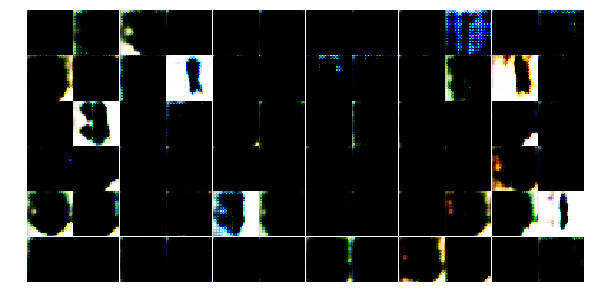

Epoch 14/20... Discriminator Loss: 0.5179... Generator Loss: 2.4299
Epoch 14/20... Discriminator Loss: 0.6737... Generator Loss: 2.0336
Epoch 14/20... Discriminator Loss: 0.8186... Generator Loss: 2.2246
Epoch 14/20... Discriminator Loss: 1.1224... Generator Loss: 0.9656
Epoch 14/20... Discriminator Loss: 0.4867... Generator Loss: 3.2385
Epoch 14/20... Discriminator Loss: 0.8113... Generator Loss: 2.1371
Epoch 14/20... Discriminator Loss: 1.0020... Generator Loss: 1.3519
Epoch 14/20... Discriminator Loss: 0.6860... Generator Loss: 2.0831
Epoch 14/20... Discriminator Loss: 0.7738... Generator Loss: 1.7678
Epoch 14/20... Discriminator Loss: 1.0616... Generator Loss: 1.8533


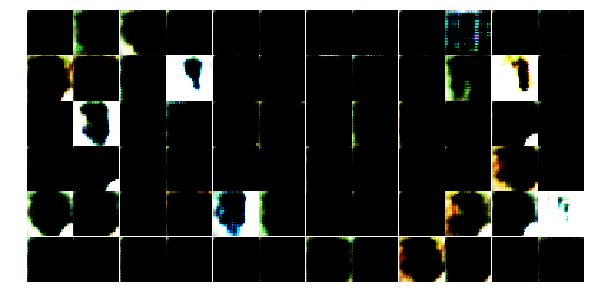

Epoch 14/20... Discriminator Loss: 1.0247... Generator Loss: 1.8608
Epoch 15/20... Discriminator Loss: 1.0381... Generator Loss: 1.1220
Epoch 15/20... Discriminator Loss: 1.0013... Generator Loss: 2.2751
Epoch 15/20... Discriminator Loss: 0.8148... Generator Loss: 2.2987
Epoch 15/20... Discriminator Loss: 0.8297... Generator Loss: 2.1805
Epoch 15/20... Discriminator Loss: 0.9831... Generator Loss: 1.1878
Epoch 15/20... Discriminator Loss: 0.7996... Generator Loss: 2.0461
Epoch 15/20... Discriminator Loss: 0.8409... Generator Loss: 1.2536
Epoch 15/20... Discriminator Loss: 0.5464... Generator Loss: 3.8118
Epoch 15/20... Discriminator Loss: 0.4889... Generator Loss: 2.8612


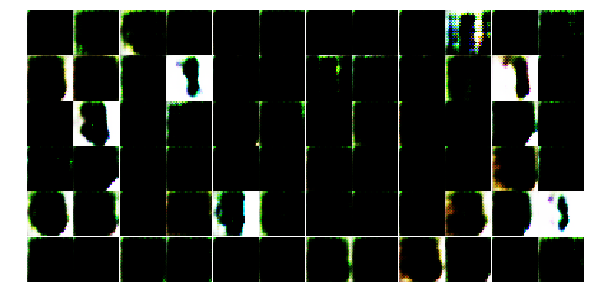

Epoch 15/20... Discriminator Loss: 0.7870... Generator Loss: 1.3637
Epoch 15/20... Discriminator Loss: 0.8891... Generator Loss: 1.8377
Epoch 15/20... Discriminator Loss: 0.7269... Generator Loss: 2.0048
Epoch 15/20... Discriminator Loss: 0.9314... Generator Loss: 1.4649
Epoch 15/20... Discriminator Loss: 0.8007... Generator Loss: 2.1116
Epoch 15/20... Discriminator Loss: 0.8460... Generator Loss: 1.2644
Epoch 15/20... Discriminator Loss: 0.5931... Generator Loss: 2.9832
Epoch 15/20... Discriminator Loss: 0.8926... Generator Loss: 1.2977
Epoch 15/20... Discriminator Loss: 1.0316... Generator Loss: 1.6217
Epoch 15/20... Discriminator Loss: 1.1774... Generator Loss: 0.9443


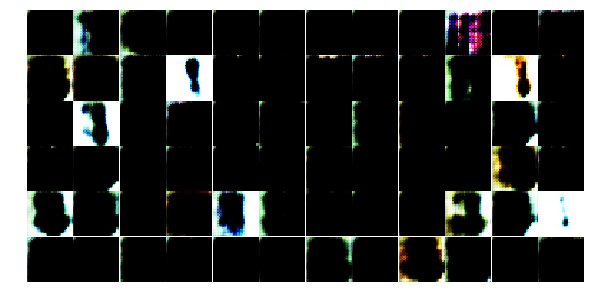

Epoch 15/20... Discriminator Loss: 0.8030... Generator Loss: 2.0005
Epoch 15/20... Discriminator Loss: 0.4757... Generator Loss: 3.3060
Epoch 15/20... Discriminator Loss: 1.1783... Generator Loss: 1.2364
Epoch 15/20... Discriminator Loss: 0.9290... Generator Loss: 1.2339
Epoch 15/20... Discriminator Loss: 1.0754... Generator Loss: 0.9344
Epoch 15/20... Discriminator Loss: 0.6765... Generator Loss: 1.8927
Epoch 15/20... Discriminator Loss: 0.7187... Generator Loss: 1.8454
Epoch 15/20... Discriminator Loss: 1.1119... Generator Loss: 1.4196
Epoch 15/20... Discriminator Loss: 0.6653... Generator Loss: 2.1253
Epoch 15/20... Discriminator Loss: 0.6396... Generator Loss: 2.0265


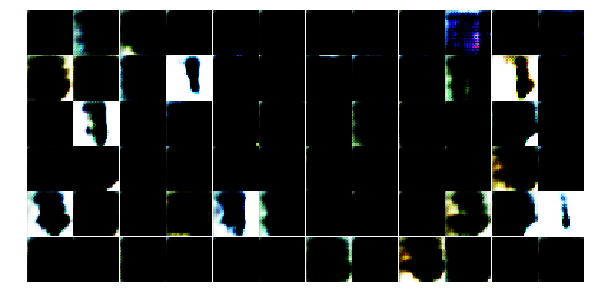

Epoch 16/20... Discriminator Loss: 0.5259... Generator Loss: 2.7657
Epoch 16/20... Discriminator Loss: 0.9936... Generator Loss: 1.2308
Epoch 16/20... Discriminator Loss: 0.6334... Generator Loss: 1.9050
Epoch 16/20... Discriminator Loss: 0.6350... Generator Loss: 2.4257
Epoch 16/20... Discriminator Loss: 0.9043... Generator Loss: 2.2394
Epoch 16/20... Discriminator Loss: 0.6529... Generator Loss: 1.8289
Epoch 16/20... Discriminator Loss: 1.2209... Generator Loss: 1.3544
Epoch 16/20... Discriminator Loss: 0.9376... Generator Loss: 1.6964
Epoch 16/20... Discriminator Loss: 1.1501... Generator Loss: 2.3300
Epoch 16/20... Discriminator Loss: 0.6136... Generator Loss: 2.1797


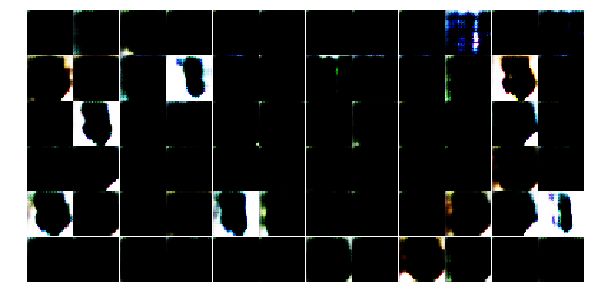

Epoch 16/20... Discriminator Loss: 1.0001... Generator Loss: 3.1104
Epoch 16/20... Discriminator Loss: 1.0994... Generator Loss: 1.5550
Epoch 16/20... Discriminator Loss: 0.6346... Generator Loss: 1.8666
Epoch 16/20... Discriminator Loss: 0.6094... Generator Loss: 1.9332
Epoch 16/20... Discriminator Loss: 1.1228... Generator Loss: 2.0899
Epoch 16/20... Discriminator Loss: 0.6686... Generator Loss: 2.2938
Epoch 16/20... Discriminator Loss: 0.7128... Generator Loss: 2.3578
Epoch 16/20... Discriminator Loss: 0.7047... Generator Loss: 3.3042
Epoch 16/20... Discriminator Loss: 0.7268... Generator Loss: 2.5160
Epoch 16/20... Discriminator Loss: 0.7381... Generator Loss: 2.2011


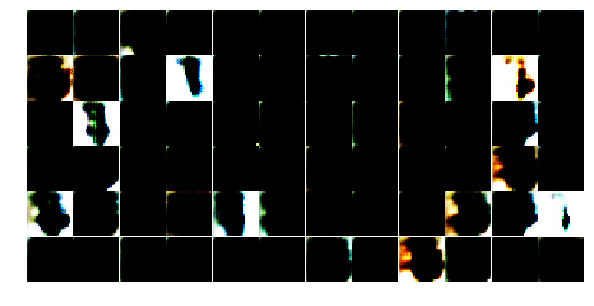

Epoch 16/20... Discriminator Loss: 0.8389... Generator Loss: 1.6462
Epoch 16/20... Discriminator Loss: 0.6937... Generator Loss: 1.9064
Epoch 16/20... Discriminator Loss: 1.1842... Generator Loss: 1.2585
Epoch 16/20... Discriminator Loss: 1.0238... Generator Loss: 1.3668
Epoch 16/20... Discriminator Loss: 0.7665... Generator Loss: 1.7531
Epoch 16/20... Discriminator Loss: 0.6004... Generator Loss: 2.3258
Epoch 16/20... Discriminator Loss: 0.5502... Generator Loss: 2.3204
Epoch 16/20... Discriminator Loss: 0.5382... Generator Loss: 2.3010
Epoch 16/20... Discriminator Loss: 0.5383... Generator Loss: 2.1748
Epoch 17/20... Discriminator Loss: 0.7282... Generator Loss: 1.5762


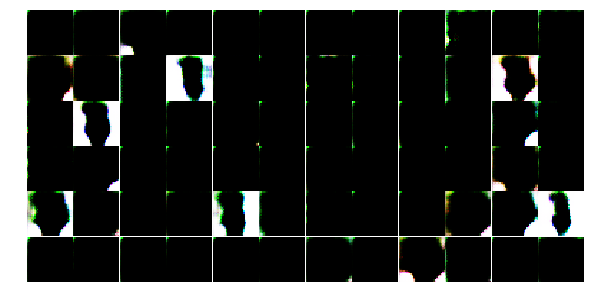

Epoch 17/20... Discriminator Loss: 0.9566... Generator Loss: 1.3384
Epoch 17/20... Discriminator Loss: 0.9121... Generator Loss: 1.6148
Epoch 17/20... Discriminator Loss: 0.5848... Generator Loss: 2.1821
Epoch 17/20... Discriminator Loss: 0.6715... Generator Loss: 2.1500
Epoch 17/20... Discriminator Loss: 0.6543... Generator Loss: 2.0517
Epoch 17/20... Discriminator Loss: 0.8130... Generator Loss: 1.4653
Epoch 17/20... Discriminator Loss: 1.1174... Generator Loss: 1.2372
Epoch 17/20... Discriminator Loss: 0.5015... Generator Loss: 2.8069
Epoch 17/20... Discriminator Loss: 0.7474... Generator Loss: 1.5708
Epoch 17/20... Discriminator Loss: 1.0181... Generator Loss: 1.4059


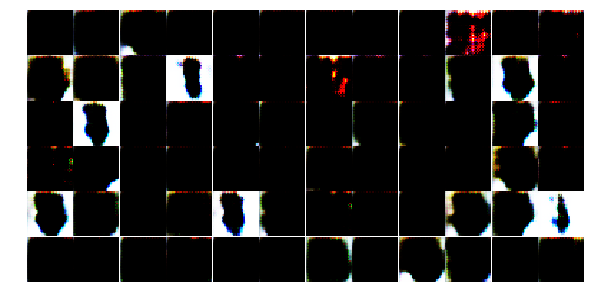

Epoch 17/20... Discriminator Loss: 0.4725... Generator Loss: 3.1831
Epoch 17/20... Discriminator Loss: 1.3949... Generator Loss: 1.6400
Epoch 17/20... Discriminator Loss: 0.4393... Generator Loss: 3.6384
Epoch 17/20... Discriminator Loss: 0.6724... Generator Loss: 1.7524
Epoch 17/20... Discriminator Loss: 1.0961... Generator Loss: 1.4716
Epoch 17/20... Discriminator Loss: 0.9297... Generator Loss: 1.2332
Epoch 17/20... Discriminator Loss: 1.1101... Generator Loss: 0.9656
Epoch 17/20... Discriminator Loss: 0.7240... Generator Loss: 1.5303
Epoch 17/20... Discriminator Loss: 0.7799... Generator Loss: 1.5494
Epoch 17/20... Discriminator Loss: 1.0066... Generator Loss: 1.4324


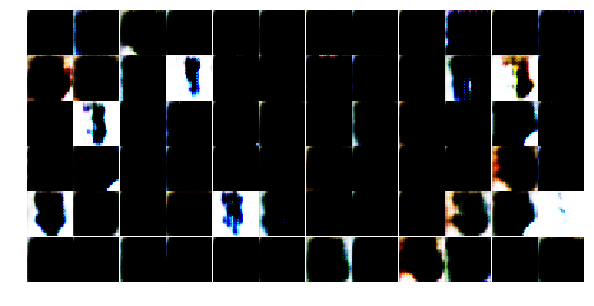

Epoch 17/20... Discriminator Loss: 0.8879... Generator Loss: 1.6092
Epoch 17/20... Discriminator Loss: 0.8725... Generator Loss: 1.5679
Epoch 17/20... Discriminator Loss: 0.8534... Generator Loss: 1.7930
Epoch 17/20... Discriminator Loss: 0.9817... Generator Loss: 1.6799
Epoch 17/20... Discriminator Loss: 0.7076... Generator Loss: 1.9622
Epoch 17/20... Discriminator Loss: 0.6799... Generator Loss: 1.9603
Epoch 17/20... Discriminator Loss: 0.8700... Generator Loss: 1.5097
Epoch 18/20... Discriminator Loss: 1.0427... Generator Loss: 1.1727
Epoch 18/20... Discriminator Loss: 0.6491... Generator Loss: 1.8949
Epoch 18/20... Discriminator Loss: 0.7882... Generator Loss: 2.0667


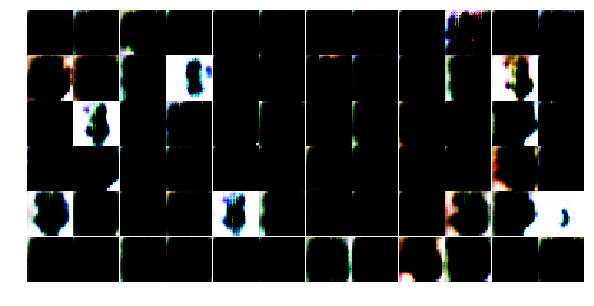

Epoch 18/20... Discriminator Loss: 0.7228... Generator Loss: 1.6154
Epoch 18/20... Discriminator Loss: 0.8125... Generator Loss: 1.5417
Epoch 18/20... Discriminator Loss: 1.0921... Generator Loss: 1.1621
Epoch 18/20... Discriminator Loss: 1.1684... Generator Loss: 2.2569
Epoch 18/20... Discriminator Loss: 0.6306... Generator Loss: 2.8296
Epoch 18/20... Discriminator Loss: 0.8273... Generator Loss: 1.3335
Epoch 18/20... Discriminator Loss: 0.7877... Generator Loss: 1.7442
Epoch 18/20... Discriminator Loss: 0.6946... Generator Loss: 2.3437
Epoch 18/20... Discriminator Loss: 0.6737... Generator Loss: 2.1490
Epoch 18/20... Discriminator Loss: 1.6484... Generator Loss: 0.7701


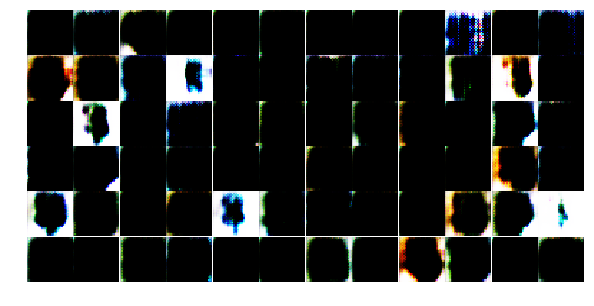

Epoch 18/20... Discriminator Loss: 0.7407... Generator Loss: 2.1426
Epoch 18/20... Discriminator Loss: 0.7664... Generator Loss: 2.0343
Epoch 18/20... Discriminator Loss: 0.6686... Generator Loss: 2.0762
Epoch 18/20... Discriminator Loss: 0.6986... Generator Loss: 1.7966
Epoch 18/20... Discriminator Loss: 0.9495... Generator Loss: 2.5166
Epoch 18/20... Discriminator Loss: 0.9049... Generator Loss: 3.2834
Epoch 18/20... Discriminator Loss: 0.5353... Generator Loss: 2.4966
Epoch 18/20... Discriminator Loss: 0.8990... Generator Loss: 1.6249
Epoch 18/20... Discriminator Loss: 1.2710... Generator Loss: 2.0167
Epoch 18/20... Discriminator Loss: 0.9056... Generator Loss: 1.8678


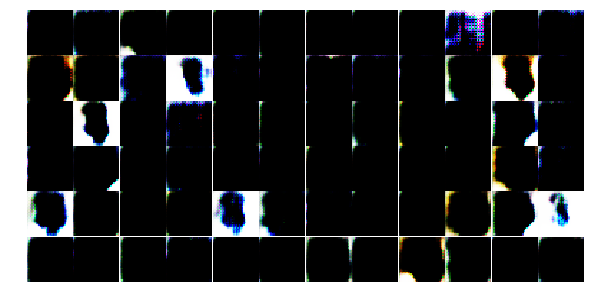

Epoch 18/20... Discriminator Loss: 1.4396... Generator Loss: 0.8150
Epoch 18/20... Discriminator Loss: 0.9732... Generator Loss: 1.3377
Epoch 18/20... Discriminator Loss: 0.8680... Generator Loss: 1.4437
Epoch 18/20... Discriminator Loss: 0.6955... Generator Loss: 2.1622
Epoch 18/20... Discriminator Loss: 0.5672... Generator Loss: 2.3547
Epoch 18/20... Discriminator Loss: 0.8947... Generator Loss: 1.5924
Epoch 19/20... Discriminator Loss: 0.7669... Generator Loss: 1.5069
Epoch 19/20... Discriminator Loss: 1.0618... Generator Loss: 1.3251
Epoch 19/20... Discriminator Loss: 0.7883... Generator Loss: 1.6596
Epoch 19/20... Discriminator Loss: 0.6411... Generator Loss: 2.0351


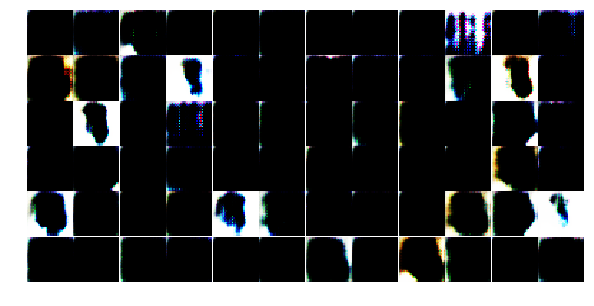

Epoch 19/20... Discriminator Loss: 0.6146... Generator Loss: 1.7925
Epoch 19/20... Discriminator Loss: 0.8458... Generator Loss: 1.3497
Epoch 19/20... Discriminator Loss: 0.8209... Generator Loss: 1.3657
Epoch 19/20... Discriminator Loss: 0.6816... Generator Loss: 2.0064
Epoch 19/20... Discriminator Loss: 0.9308... Generator Loss: 1.3730
Epoch 19/20... Discriminator Loss: 1.1688... Generator Loss: 1.3024
Epoch 19/20... Discriminator Loss: 1.4089... Generator Loss: 2.0885
Epoch 19/20... Discriminator Loss: 0.7760... Generator Loss: 1.6130
Epoch 19/20... Discriminator Loss: 0.8890... Generator Loss: 1.7758
Epoch 19/20... Discriminator Loss: 0.9291... Generator Loss: 1.5523


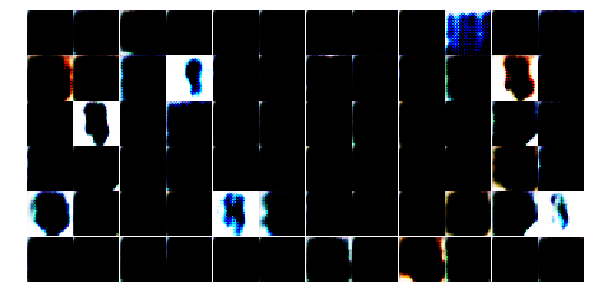

Epoch 19/20... Discriminator Loss: 0.7188... Generator Loss: 1.9298
Epoch 19/20... Discriminator Loss: 1.0150... Generator Loss: 1.6609
Epoch 19/20... Discriminator Loss: 0.7465... Generator Loss: 1.9271
Epoch 19/20... Discriminator Loss: 0.7744... Generator Loss: 2.2453
Epoch 19/20... Discriminator Loss: 0.8437... Generator Loss: 1.6992
Epoch 19/20... Discriminator Loss: 0.7124... Generator Loss: 1.8073
Epoch 19/20... Discriminator Loss: 0.6374... Generator Loss: 1.8905
Epoch 19/20... Discriminator Loss: 0.5577... Generator Loss: 2.5105
Epoch 19/20... Discriminator Loss: 0.5043... Generator Loss: 2.6443
Epoch 19/20... Discriminator Loss: 0.5771... Generator Loss: 2.0975


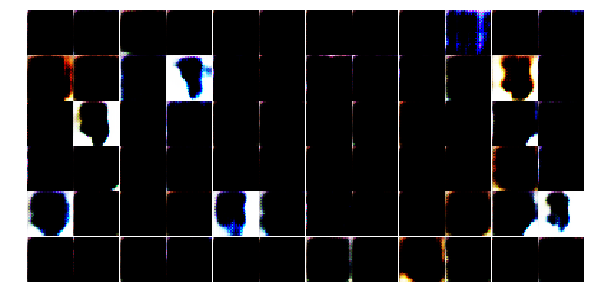

Epoch 19/20... Discriminator Loss: 0.8324... Generator Loss: 1.9452
Epoch 19/20... Discriminator Loss: 0.8754... Generator Loss: 1.8256
Epoch 19/20... Discriminator Loss: 0.7139... Generator Loss: 2.6039
Epoch 19/20... Discriminator Loss: 0.7000... Generator Loss: 2.3040
Epoch 19/20... Discriminator Loss: 1.0032... Generator Loss: 2.2196
Epoch 20/20... Discriminator Loss: 0.6948... Generator Loss: 2.3886
Epoch 20/20... Discriminator Loss: 0.6249... Generator Loss: 1.9545
Epoch 20/20... Discriminator Loss: 0.6301... Generator Loss: 3.0296
Epoch 20/20... Discriminator Loss: 1.2147... Generator Loss: 1.1624
Epoch 20/20... Discriminator Loss: 0.6233... Generator Loss: 2.5153


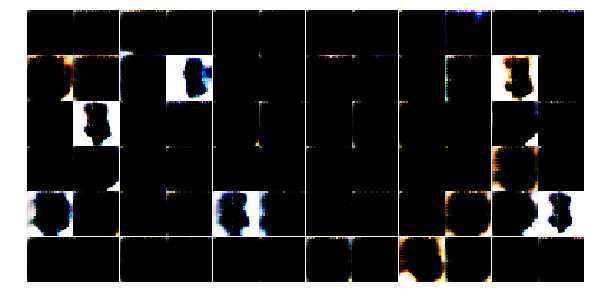

Epoch 20/20... Discriminator Loss: 0.7470... Generator Loss: 1.9164
Epoch 20/20... Discriminator Loss: 0.4992... Generator Loss: 2.7839
Epoch 20/20... Discriminator Loss: 0.6687... Generator Loss: 1.8257
Epoch 20/20... Discriminator Loss: 1.0673... Generator Loss: 1.1921
Epoch 20/20... Discriminator Loss: 0.8437... Generator Loss: 1.8267
Epoch 20/20... Discriminator Loss: 0.6353... Generator Loss: 2.1386
Epoch 20/20... Discriminator Loss: 0.5725... Generator Loss: 2.1839
Epoch 20/20... Discriminator Loss: 0.7741... Generator Loss: 1.5142
Epoch 20/20... Discriminator Loss: 0.7606... Generator Loss: 2.0124
Epoch 20/20... Discriminator Loss: 0.8219... Generator Loss: 1.7781


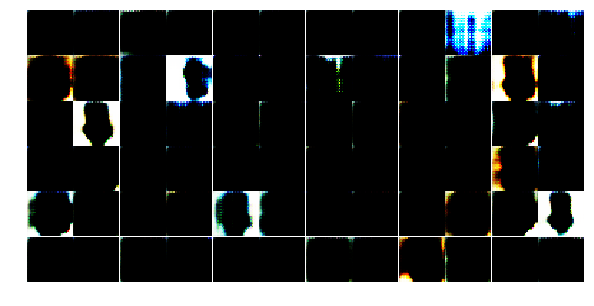

Epoch 20/20... Discriminator Loss: 0.7635... Generator Loss: 1.5056
Epoch 20/20... Discriminator Loss: 0.7787... Generator Loss: 2.0681
Epoch 20/20... Discriminator Loss: 0.5386... Generator Loss: 2.5053
Epoch 20/20... Discriminator Loss: 0.7755... Generator Loss: 1.8482
Epoch 20/20... Discriminator Loss: 0.6793... Generator Loss: 1.9954
Epoch 20/20... Discriminator Loss: 0.9386... Generator Loss: 1.6718
Epoch 20/20... Discriminator Loss: 1.1201... Generator Loss: 1.2477
Epoch 20/20... Discriminator Loss: 0.8035... Generator Loss: 2.1976
Epoch 20/20... Discriminator Loss: 0.5419... Generator Loss: 3.0756
Epoch 20/20... Discriminator Loss: 0.7992... Generator Loss: 2.2923


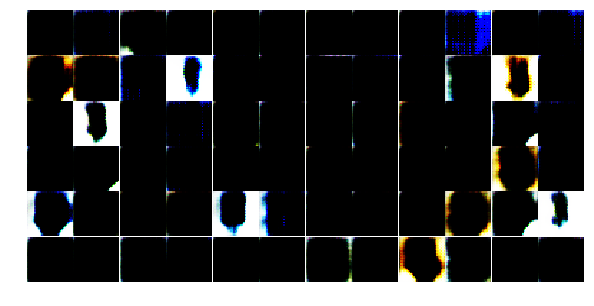

Epoch 20/20... Discriminator Loss: 0.9270... Generator Loss: 1.6071
Epoch 20/20... Discriminator Loss: 1.1281... Generator Loss: 1.3130
Epoch 20/20... Discriminator Loss: 1.0739... Generator Loss: 0.9250
Epoch 20/20... Discriminator Loss: 1.0133... Generator Loss: 1.2178


In [39]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5), writer_dis=writer_discriminator, writer_gen=writer_generator)

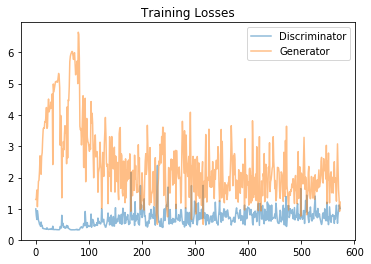

In [40]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


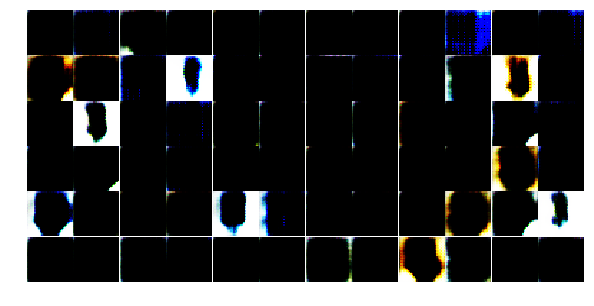

In [41]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))